<style>
h3.indent {
    margin-left: 20px; /* ajusta este valor para más o menos sangría */
}
</style>

# Laboratorio 4
### Análisis de modelos usando datos geospaciales.

**Integrantes:**  
* Francis Aguilar 22243 
* Angela García 22869
* César López 22404

# Resolviendo ejercicio de la practica: 

1. Muestre el mapa en true color del lago de Amatitlan.  
2. Calcule los índices NDVI y NDWI para el lago de amatitlán y muestre los mapas.  
3. Discuta semejanzas y diferencias sobre los índices en ambos lagos

In [18]:
#!pip install openeo
#!pip install rasterio

In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
import openeo

In [20]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [21]:
lago_amatitlan = {
"west": -90.638065,
"east": -90.512924,
"south": 14.412347,
"north": 14.493799
}


In [22]:
amatitlan_cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=lago_amatitlan,  # Región de Guatemala
    temporal_extent=["2025-02-07", "2025-02-07"],  # Usa fechas pasadas, no futuras
    bands=["B02","B03","B04", "B08"]
)

In [23]:
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

In [25]:
result_graph = amatitlan_cube.save_result(format="GTIFF")
job = connection.create_job(result_graph)
job.start_and_wait()
job.download_results("imgs/Bandas_Amatitlan_try_2.tiff")

0:00:00 Job 'j-2508112327364ab3a033d0d9f71bc08b': send 'start'
0:00:14 Job 'j-2508112327364ab3a033d0d9f71bc08b': created (progress 0%)
0:00:19 Job 'j-2508112327364ab3a033d0d9f71bc08b': created (progress 0%)
0:00:26 Job 'j-2508112327364ab3a033d0d9f71bc08b': created (progress 0%)
0:00:34 Job 'j-2508112327364ab3a033d0d9f71bc08b': running (progress N/A)
0:00:44 Job 'j-2508112327364ab3a033d0d9f71bc08b': running (progress N/A)
0:00:56 Job 'j-2508112327364ab3a033d0d9f71bc08b': running (progress N/A)
0:01:12 Job 'j-2508112327364ab3a033d0d9f71bc08b': running (progress N/A)
0:01:31 Job 'j-2508112327364ab3a033d0d9f71bc08b': finished (progress 100%)


C:\Users\MSI\AppData\Local\Temp\ipykernel_18604\2298015516.py:4: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results("imgs/Bandas_Amatitlan_try_2.tiff")


{WindowsPath('imgs/Bandas_Amatitlan_try_2.tiff'): {'bands': [{'eo:center_wavelength': 0.4924,
    'eo:common_name': 'blue',
    'name': 'B02'},
   {'eo:center_wavelength': 0.5598, 'eo:common_name': 'green', 'name': 'B03'},
   {'eo:center_wavelength': 0.6646, 'eo:common_name': 'red', 'name': 'B04'},
   {'eo:center_wavelength': 0.8328, 'eo:common_name': 'nir', 'name': 'B08'}],
  'eo:bands': [{'center_wavelength': 0.4924,
    'common_name': 'blue',
    'name': 'B02'},
   {'center_wavelength': 0.5598, 'common_name': 'green', 'name': 'B03'},
   {'center_wavelength': 0.6646, 'common_name': 'red', 'name': 'B04'},
   {'center_wavelength': 0.8328, 'common_name': 'nir', 'name': 'B08'}],
  'href': 'https://openeo.dataspace.copernicus.eu/openeo/1.2/jobs/j-2508112327364ab3a033d0d9f71bc08b/results/assets/ZTAwODlhNTctNTQyMC00YTIwLWEzMGItYjhjNzA5ZTA1ZDEw/8422c632b151a9a109c57c307e75f4f7/openEO_2025-02-07Z.tif?expires=1755559749',
  'proj:bbox': [754570, 1594630, 768170, 1603800],
  'proj:epsg': 32615,

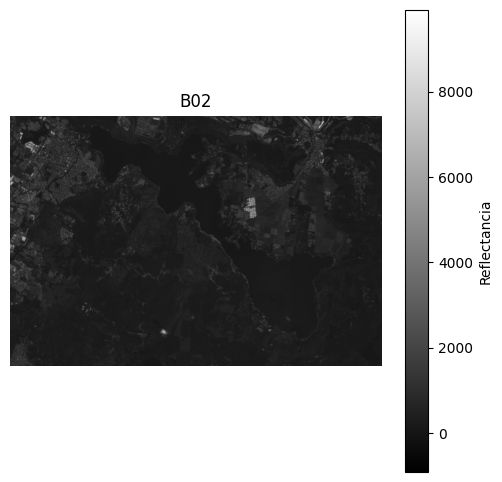

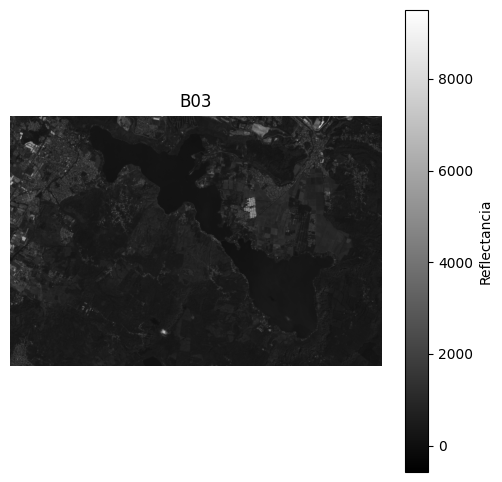

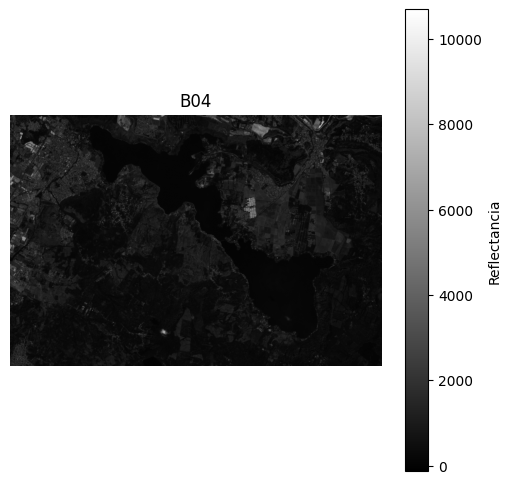

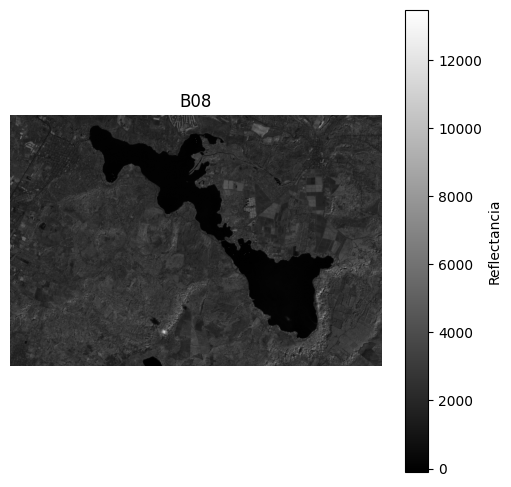

In [26]:
ruta_tif = "imgs/Bandas_Amatitlan_try_2.tiff"

with rasterio.open(ruta_tif) as src:
    bandas = src.read()  # Lee todas las bandas
    nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
    nodata = src.nodata

# Visualizar bandas individuales
for i in range(bandas.shape[0]):
    plt.figure(figsize=(6, 6))
    img = bandas[i]
    img = np.ma.masked_where(img == nodata, img)
    plt.imshow(img, cmap='gray')
    plt.title(f"{nombres[i]}")
    plt.axis('off')
    plt.colorbar(label="Reflectancia")
    plt.show()

Mostrar en falso color

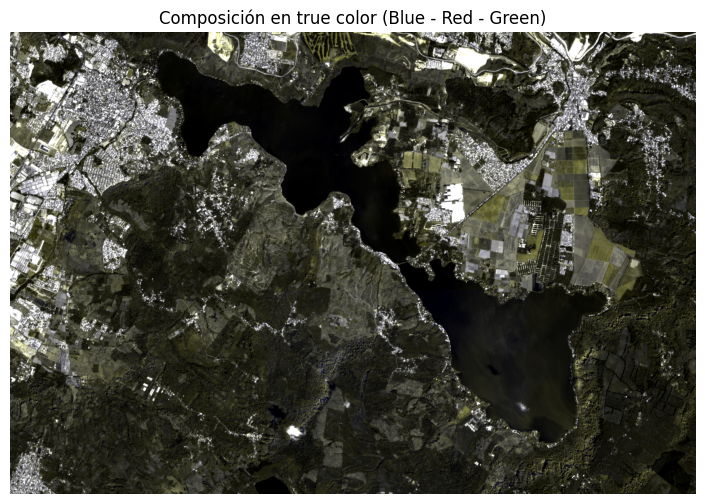

In [27]:
# Normalizador
def normalize(b):
    b_min, b_max = np.percentile(b[b > 0], (2, 98))
    return np.clip((b - b_min) / (b_max - b_min), 0, 1)

blue = bandas[0]   #B02
green = bandas[1]  # B03
red = bandas[1]    # B04
nir = bandas[2]    # B08

# Reasignar correctamente:
b = normalize(blue)  # B02
g = normalize(green)    # B03
r = normalize(red)    # B04
n = normalize(blue)    # B08

# Falso color (NIR NearInfrared, Red, Green)
rgb = np.dstack([r, g, b])

plt.figure(figsize=(10, 6))
plt.imshow(rgb)
plt.title("Composición en true color (Blue - Red - Green)")
plt.axis('off')
plt.show()


## NDVI (Sentinel 2) = (B8 - B4) / (B8 + B4)

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Convertir a float32 y escalar a reflectancia (0–1)
red_scale = red.astype(np.float32) / 10000  # B04
nir_scale = nir.astype(np.float32) / 10000  # B08
green_scale = green.astype(np.float32) / 10000  # B03
blue_scale = blue.astype(np.float32) / 10000  # B02

# Calcular NDVI
ndvi_amatitlan = np.where(
    (nir_scale + red_scale) == 0,
    0,
    (nir_scale - red_scale) / (nir_scale + red_scale)
)

ndvi_amatitlan


array([[-0.00545124, -0.00777607,  0.14308053, ..., -0.1816092 ,
        -0.1461717 ,  0.03986135],
       [ 0.03741496,  0.06760849,  0.13630228, ...,  0.0093458 ,
         0.09145132,  0.0745836 ],
       [ 0.04672896,  0.04136254,  0.10886644, ...,  0.03839543,
         0.0504396 ,  0.03209879],
       ...,
       [ 0.02259888,  0.01703578,  0.1238938 , ...,  0.04733133,
         0.09304815,  0.07304118],
       [-0.00736195,  0.14784129,  0.06709265, ...,  0.03544576,
         0.09846827, -0.02550334],
       [ 0.07979628,  0.06584045,  0.10759077, ...,  0.00910274,
         0.        , -0.06857142]], shape=(917, 1360), dtype=float32)

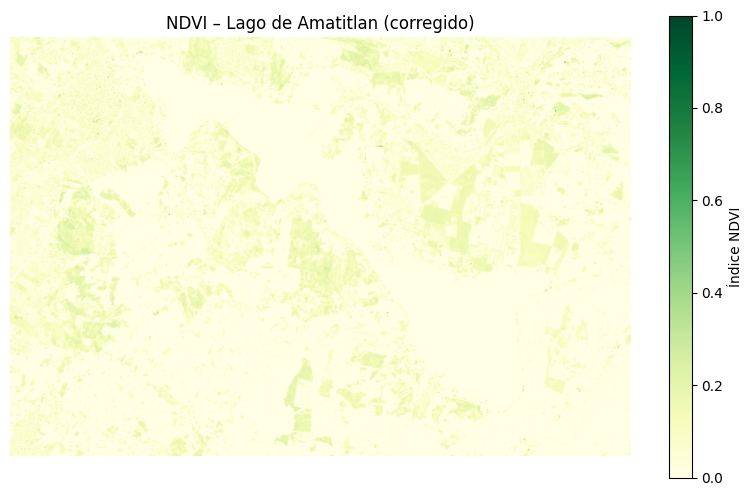

In [29]:
# Mostrar NDVI
plt.figure(figsize=(10, 6))
plt.imshow(ndvi_amatitlan, cmap='YlGn', vmin=0, vmax=1)
plt.title("NDVI – Lago de Amatitlan (corregido)")
plt.colorbar(label="Índice NDVI")
plt.axis('off')
plt.show()

| NDVI          | Interpretación                                |
| ------------- | --------------------------------------------- |
| **0.6 a 1.0** | Vegetación muy densa y sana                   |
| **0.4 a 0.6** | Vegetación saludable (cultivos, bosques)      |
| **0.2 a 0.4** | Vegetación escasa o en estrés                 |
| **0.0 a 0.2** | Suelo desnudo, hierba seca                    |
| **< 0.0**     | Agua, nubes, nieve o superficies artificiales |


## NDWI

In [31]:
ndwi_amatitlan = np.where(
    (green + nir) == 0,
    0,
    (green - nir) / (green + nir)
)
ndwi_amatitlan

array([[ 0.00545124,  0.00777605, -0.14308053, ...,  0.1816092 ,
         0.14617169, -0.03986135],
       [-0.03741497, -0.06760848, -0.13630229, ..., -0.00934579,
        -0.09145129, -0.07458364],
       [-0.04672897, -0.04136253, -0.10886644, ..., -0.03839542,
        -0.05043961, -0.03209877],
       ...,
       [-0.02259887, -0.01703578, -0.12389381, ..., -0.04733132,
        -0.09304813, -0.07304117],
       [ 0.00736196, -0.14784126, -0.06709265, ..., -0.03544576,
        -0.09846827,  0.02550336],
       [-0.07979626, -0.06584043, -0.10759076, ..., -0.00910273,
         0.        ,  0.06857143]], shape=(917, 1360))

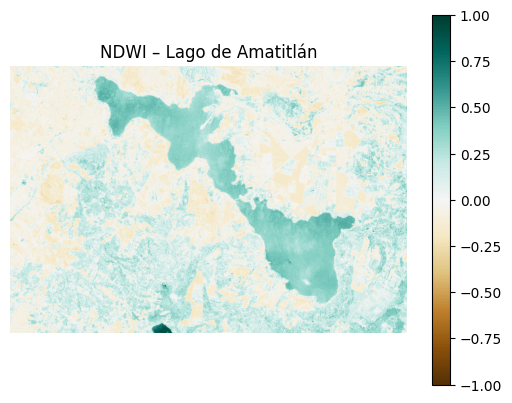

In [32]:
plt.imshow(ndwi_amatitlan, cmap='BrBG', vmin=-1, vmax=1)
plt.title("NDWI – Lago de Amatitlán")
plt.colorbar()
plt.axis('off')
plt.show()

| NDWI        | Interpretación                       |
| ----------- | ------------------------------------ |
| **> 0.2**   | Agua o zonas húmedas                 |
| **0 a 0.2** | Vegetación poco densa o suelo húmedo |
| **< 0**     | Vegetación o suelo seco              |


# Lab 4 - Primeros Avances

## &nbsp;&nbsp;Funciones

### &nbsp;&nbsp;&nbsp;&nbsp;Utils

In [15]:
def dict_converter(bandas, names):
    # Convierte a dict 
    out = {}
    for i, nm in enumerate(names):
        out[nm] = bandas[i]
    return out

### &nbsp;&nbsp;&nbsp;&nbsp;Cubo de inspeccion

In [ ]:
# Función para obtener el cubo de datos
def getCube(day: str, spatial_extent, connection):
    cube = connection.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=spatial_extent,  # Región de Guatemala
        temporal_extent=[day, day],  # Usa fechas pasadas, no futuras
        bands=["B02","B03","B04", "B05", "B07", "B08", "B8A"]
    )

    return cube

# Función para descargar la imagen del cubo
def getImage(day: str, cube, connection, lake):
    result_graph = cube.save_result(format="GTIFF")
    job = connection.create_job(result_graph)
    job.start_and_wait()
    output_dir = f"imgs/Bandas_{lake}/day_{day}.tiff"
    job.download_results(output_dir)
    print(f"Downloaded image for day {day}")

    return output_dir


# Función para obtener las bandas de la imagen
def getBands(ruta_tiff: str): 
    with rasterio.open(ruta_tiff) as src:
        bandas = src.read()  # Lee todas las bandas
        nombres = src.descriptions if src.descriptions[0] else [f"Banda {i+1}" for i in range(src.count)]
        nodata = src.nodata
    
    return bandas, nombres, nodata


# Normalizador
def normalize(b):
    b_min, b_max = np.percentile(b[b > 0], (2, 98))
    return np.clip((b - b_min) / (b_max - b_min), 0, 1)

def getTrueColors(bandas):
    blue = bandas[0]   #B02
    green = bandas[1]  # B03
    red = bandas[1]    # B04
    nir = bandas[2]    # B08

    return  blue, green, red, nir


### &nbsp;&nbsp;&nbsp;&nbsp;Graficas

In [14]:
def NDWI_graf(ndwi, day): 
    plt.imshow(ndwi, cmap='BrBG', vmin=-1, vmax=1)
    plt.title(f"NDWI – Lago de Amatitlán en {day}")
    plt.colorbar()
    plt.axis('off')
    plt.show()

def NDVI_graf(ndvi, day): 
    plt.figure(figsize=(10, 6))
    plt.imshow(ndvi, cmap='YlGn', vmin=0, vmax=1)
    plt.title(f"NDVI – Lago de Amatitlán en {day}")
    plt.colorbar(label="Índice NDVI")
    plt.axis('off')
    plt.show()

# Funcion para graficar bandas de cada imagen
def bands_Graf(bandas, nombres, nodata):
    for i in range(bandas.shape[0]):
        plt.figure(figsize=(6, 6))
        img = bandas[i]
        img = np.ma.masked_where(img == nodata, img)
        plt.imshow(img, cmap='gray')
        plt.title(f"{nombres[i]}")
        plt.axis('off')
        plt.colorbar(label="Reflectancia")
        plt.show()

# Funcion para graficar imagenes en true color
def trueColors_Graph(blue, green, red): 
    b = normalize(blue)  # B02
    g = normalize(green)    # B03
    r = normalize(red)    # B04
    n = normalize(blue)    # B08

    # Falso color (NIR NearInfrared, Red, Green)
    rgb = np.dstack([r, g, b])

    plt.figure(figsize=(10, 6))
    plt.imshow(rgb)
    plt.title("Composición en true color (Blue - Red - Green)")
    plt.axis('off')
    plt.show()

### &nbsp;&nbsp;&nbsp;&nbsp;Indices

In [ ]:

def getNDWI(green, nir, day):
    ndwi = np.where(
        (green + nir) == 0,
        0,
        (green - nir) / (green + nir)
    )
    print(f"Indice NDWI para {day}: {ndwi}")
    return ndwi


def getNDVI(red, nir, day):
    red_scale = red.astype(np.float32) / 10000  # B04
    nir_scale = nir.astype(np.float32) / 10000  # B08
    # Calcular NDVI
    ndvi = np.where(
        (nir_scale + red_scale) == 0,
        0,
        (nir_scale - red_scale) / (nir_scale + red_scale)
    )

    print(f"Indice NDVI para {day}: {ndvi}")

    return ndvi


### &nbsp;&nbsp;&nbsp;&nbsp;Cyanobacteria

In [ ]:

# --- Cyanobacteria Chlorophyll-a NDCI L1C Evalscript pasado a python ---

# Water body detection - credit Mohor Gartner
MNDWI_threshold = 0.42
NDWI_threshold = 0.4
filter_UABS = True
filter_SSI = False

def wbi(r, g, b, nir, swir1, swir2):
    # water surface
    ws = 0
    try:
        # Calc indices
        ndvi = (nir - r) / (nir + r)
        mndwi = (g - swir1) / (g + swir1)
        ndwi = (g - nir) / (g + nir)
        ndwi_leaves = (nir - swir1) / (nir + swir1)
        aweish = b + 2.5 * g - 1.5 * (nir + swir1) - 0.25 * swir2
        aweinsh = 4 * (g - swir1) - (0.25 * nir + 2.75 * swir1)

        dbsi = ((swir1 - g) / (swir1 + g)) - ndvi
        wii = np.power(nir, 2) / r
        wri = (g + r) / (nir + swir1)
        puwi = 5.83 * g - 6.57 * r - 30.32 * nir + 2.25
        uwi = (g - 1.1 * r - 5.2 * nir + 0.4) / np.abs(g - 1.1 * r - 5.2 * nir)
        usi = 0.25 * (g / r) - 0.57 * (nir / g) - 0.83 * (b / g) + 1

        if (mndwi > MNDWI_threshold or ndwi > NDWI_threshold or
            aweinsh > 0.1879 or aweish > 0.1112 or
            ndvi < -0.2 or ndwi_leaves > 1):
            ws = 1

        if filter_UABS and ws == 1:
            if (aweinsh <= -0.03) or (dbsi > 0):
                ws = 0

    except Exception:
        ws = 0
    return ws

# Floating vegetation
def FAI(a, b, c):
    return b - a - (c - a) * (783 - 665) / (865 - 665)

# Chlorophyll-a
def NDCI(a, b):
    return (b - a) / (b + a)

In [ ]:
# No creo utilizarla por ahora pero estaba en el evalscript
def classify_pixel(B02, B03, B04, B05, B07, B08, B8A, B11, B12):
    water = wbi(B04, B03, B02, B08, B11, B12)
    FAIv = FAI(B04, B07, B8A)
    NDCIv = NDCI(B04, B05)
    chl = 826.57 * NDCIv**3 - 176.43 * NDCIv**2 + 19 * NDCIv + 4.071

    trueColor = [3 * B04, 3 * B03, 3 * B02]

    #  Render colour map
    if water == 0:
        return trueColor
    elif FAIv > 0.08:
        return [233/255, 72/255, 21/255]
    elif chl < 0.5:
        return [0, 0, 1.0]
    elif chl < 1:
        return [0, 0, 1.0]
    elif chl < 2.5:
        return [0, 59/255, 1]
    elif chl < 3.5:
        return [0, 98/255, 1]
    elif chl < 5:
        return [15/255, 113/255, 141/255]
    elif chl < 7:
        return [14/255, 141/255, 120/255]
    elif chl < 8:
        return [13/255, 141/255, 103/255]
    elif chl < 10:
        return [30/255, 226/255, 28/255]
    elif chl < 14:
        return [42/255, 226/255, 28/255]
    elif chl < 18:
        return [68/255, 226/255, 28/255]
    elif chl < 20:
        return [68/255, 226/255, 28/255]
    elif chl < 24:
        return [134/255, 247/255, 0]
    elif chl < 28:
        return [140/255, 247/255, 0]
    elif chl < 30:
        return [205/255, 237/255, 0]
    elif chl < 38:
        return [208/255, 240/255, 0]
    elif chl < 45:
        return [208/255, 240/255, 0]
    elif chl < 50:
        return [251/255, 210/255, 3/255]
    elif chl < 75:
        return [248/255, 207/255, 2/255]
    elif chl < 90:
        return [134/255, 247/255, 0]
    elif chl < 100:
        return [245/255, 164/255, 9/255]
    elif chl < 150:
        return [240/255, 159/255, 8/255]
    elif chl < 250:
        return [237/255, 157/255, 7/255]
    elif chl < 300:
        return [239/255, 118/255, 15/255]
    elif chl < 350:
        return [239/255, 101/255, 15/255]
    elif chl < 450:
        return [239/255, 100/255, 14/255]
    elif chl < 500:
        return [233/255, 72/255, 21/255]
    else:
        return [233/255, 72/255, 21/255]


## &nbsp;&nbsp;Constantes

### Fechas y diccionarios de indices

In [16]:
DATES = [
    "2025-02-07",
    "2025-02-10",
    "2025-02-25",
    "2025-02-27",
    "2025-03-02",
    "2025-03-04",
    "2025-03-07",
    "2025-03-09",
    "2025-03-12",
    "2025-03-14",
    "2025-03-19",
    "2025-03-22",
    "2025-03-24",
    "2025-03-26",
    "2025-04-03",
    "2025-04-11",
    "2025-04-13",
    "2025-04-15",
    "2025-04-16",
    "2025-04-18",
    "2025-04-28",
    "2025-05-03",
    "2025-05-13",
    "2025-05-28",
    "2025-07-10",
    "2025-07-17",
    "2025-07-20",
    "2025-07-24",
    "2025-08-01",
]
ndvi = {}
ndwi = {}
ndci = {}
fai  = {}

### Coneccion

In [7]:
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


### Coordenadas

In [8]:
lago_atitlan = {
"west": -91.326256,
"east": -91.07151,
"south": 14.5948,
"north": 14.750979
}

lago_amatitlan = {
"west": -90.638065,
"east": -90.512924,
"south": 14.412347,
"north": 14.493799
}

## &nbsp;&nbsp;Script para indices (ultimos 6 meses)

In [ ]:
# Data para 
for day in DATES:
    # Lago Amatitlan
    amatitlan_cube = getCube(day, lago_amatitlan, connection)
    amatilan_ruta = getImage(day, amatitlan_cube, connection, "Amatitlan")
    amatitlan_bandas, amatitlan_nombres, amatitlan_nodata = getBands(amatilan_ruta)
    blue, green, red, nir = getTrueColors(amatitlan_bandas)
    ndvi[f"Amatitlan - {day}"] = getNDVI(day)
    ndwi[f"Amatitlan - {day}"] = getNDWI(green, nir, day)
    ndci[f"Amatitlan - {day}"] = NDCI(amatitlan_bandas[2], amatitlan_bandas[3])
    fai[f"Amatitlan - {day}"] = FAI(amatitlan_bandas[2], amatitlan_bandas[4], amatitlan_bandas[6])


    # Lago Atitlan
    atitlan_cube = getCube(day, lago_atitlan, connection)
    atitlan_ruta = getImage(day, atitlan_cube, connection, "Atitlan")
    atitlan_bandas, atitlan_nombres, atitlan_nodata = getBands(atitlan_ruta)
    blue, green, red, nir = getTrueColors(atitlan_bandas)
    ndvi[f"Atitlan - {day}"] = getNDVI(red, nir, green, blue, day)
    ndwi[f"Atitlan - {day}"] = getNDWI(green, nir, day)
    ndci[f"Atitlan - {day}"] = NDCI(atitlan_bandas[2], atitlan_bandas[3])
    fai[f"Atitlan - {day}"] = FAI(atitlan_bandas[2], atitlan_bandas[4], atitlan_bandas[6])


0:00:00 Job 'j-25081301135840af8f1f6be58f8952c9': send 'start'
0:00:13 Job 'j-25081301135840af8f1f6be58f8952c9': queued (progress 0%)
0:00:18 Job 'j-25081301135840af8f1f6be58f8952c9': queued (progress 0%)
0:00:25 Job 'j-25081301135840af8f1f6be58f8952c9': queued (progress 0%)
0:00:33 Job 'j-25081301135840af8f1f6be58f8952c9': queued (progress 0%)
0:00:43 Job 'j-25081301135840af8f1f6be58f8952c9': queued (progress 0%)
0:00:55 Job 'j-25081301135840af8f1f6be58f8952c9': queued (progress 0%)
0:01:11 Job 'j-25081301135840af8f1f6be58f8952c9': running (progress N/A)
0:01:30 Job 'j-25081301135840af8f1f6be58f8952c9': running (progress N/A)
0:01:54 Job 'j-25081301135840af8f1f6be58f8952c9': running (progress N/A)
0:02:24 Job 'j-25081301135840af8f1f6be58f8952c9': finished (progress 100%)


C:\Users\MSI\AppData\Local\Temp\ipykernel_2720\3675364395.py:18: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(output_dir)
c:\Users\MSI\Desktop\info\Escritorio\UVG\8vo Semestre\Data Science\DSvenv\Lib\site-packages\openeo\rest\job.py:199: UserDeprecationWarning: Call to deprecated method get_result. (Use `BatchJob.get_results` instead.) -- Deprecated since version 0.4.10.
  return self.get_result().download_files(target)
c:\Users\MSI\Desktop\info\Escritorio\UVG\8vo Semestre\Data Science\DSvenv\Lib\site-packages\openeo\rest\job.py:203: UserDeprecationWarning: Call to deprecated class _Result. (Use `JobResults` instead) -- Deprecated since version 0.4.10.
  return _Result(self)


OpenEoClientException: Target argument imgs\Bandas_Amatitlan_day_2025-02-07.tiff exists but isn't a folder.